In [81]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_del_accumulation_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import json
import math

## Figure 1 follow-up: Correlation of accumulation of nonsynonymous mutations with clade success, split by region instead of global


Get information about genome position and length of each gene 

In [4]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Make a list of regions of the genome to consider. Each element of the list is a tuple with the format: 
(region/type of mutation, node attribute name, gene length for normalizing mutation count, nonsynonymous or synonymous)

In [15]:
genes_to_consider = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S1_synonymous', 's1_syn_accumulation', 'S1', 'syn'), 
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('E', 'e_accumulation', 'E', 'nonsyn'), ('M', 'm_accumulation', 'M', 'nonsyn'), 
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn'), 
                       ('S2', 's2_accumulation', 'S2', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn')]


For each geographic region, find mutation accumulation and growth rate of clades to run the correlations from Fig1B (which uses a global phylogeny)

In [43]:
def get_regional_tree_data(region):
    #import tree
    if region =='global':
        tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'
    else:
        tree_url = f'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15_{region}.json'
    tree_json = requests.get(tree_url).json()
    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    # add information about synonymous muts as an attribute of the tree
    tree = add_syn_mut_attribute(tree)
    
    # add an attribute to each node that gives the total number of mutations 
    # (synonymous SNPs or nonsynonymous SNPs plus deletions)
    # accumulated between the tree root and that node (including muts on the node)
    tree = add_mut_accumulation_attr(tree)
    
    #make a dataframe withrelevant information for Fig1B
    muts_information = []

    # only look at internal nodes
    for node in tree.find_clades(terminal=False):

        # only nodes within 6 weeks of May 15 have logisitic growth rates
        logistic_growth = None
        if "logistic_growth" in node.node_attrs:
            logistic_growth = node.node_attrs["logistic_growth"]["value"]

        if hasattr(node, "node_attrs"):
            # get inferred node date
            date = node.node_attrs["num_date"]["value"]

            # get emerging lineage assignment of node 
            if 'emerging_lineage' in node.node_attrs:
                emerging_lineage = node.node_attrs['emerging_lineage']['value']
                emerging_lineage = convert_linege_names(emerging_lineage)

            # make tidy df for seaborn plotting
            for r in genes_to_consider:
                # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
                # add figure_lineage key to group 
                muts_information.append({'clade': node.name, 'date': date, 'region': region,
                                         'emerging_lineage': emerging_lineage,
                                         'mut_location': r[0], 
                                         'num_muts': node.node_attrs[r[1]],  
                                         'muts_per_codon': node.node_attrs[r[1]]/gene_lengths_aa[r[2]],
                                         'logistic_growth': logistic_growth})


    # make list into dataframe
    muts_information_df = pd.DataFrame(muts_information)
    
    return muts_information_df
    

In [19]:
def concatenate_all_regions(regions):
    
    # initialize dataframe to store data from all regions
    muts_df = pd.DataFrame(columns = ['clade', 'date', 'region', 
                                      'emerging_lineage', 'mut_location', 
                                      'num_muts', 'muts_per_codon', 'logistic_growth'])
    
    for r in regions:
        muts_information_region = get_regional_tree_data(r)
        muts_df = pd.concat([muts_df, muts_information_region])
        
    return muts_df

In [82]:
muts_df = concatenate_all_regions(['global','africa', 'asia','europe', 'northamerica', 'oceania', 'southamerica'])

In [83]:
# add column to color lineages as is done in manuscript for the primary analysis
manuscript_lineage_map = {'basal': 'basal',
 'A.23.1': 'other VOI',
 'B.1.351 (Beta)': 'Beta',
 'B.1.526 (Iota)': 'other VOI',
 'B.1.621': 'other VOI',
 'B.1.427/429 (Epsilon)': 'other VOI',
 'B.1.620': 'other VOI',
 'B.1.617.1 (Kappa)': 'other VOI',
 'B.1.617.2 (Delta)': 'Delta',
 'B.1.619': 'other VOI',
 'B.1.525 (Eta)': 'other VOI',
 'B.1.1.7 (Alpha)': 'Alpha',
 'P.1 (Gamma)': 'Gamma',
 'C.36.3': 'other VOI',
 'C.37 (Lambda)': 'other VOI',
 'B.1.1.519': 'other VOI',
 'B.1.1.318': 'other VOI'}

muts_df['manuscript_lineage'] = muts_df['emerging_lineage'].map(manuscript_lineage_map)

Now plot Figure1 B: mutation accumulation versus clade growth rate for S1 nonsyn, syn and RdRp nonsyn. Plot each geographic region separately

In [179]:
def plot_fig1ab(regions, filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}


    # dictionary to convert labels to more readable labels
    readable_labels = {'nonsyn': 'Nonsynonymous', 'syn': 'Synonymous'}
    # whether or not to plot legend, based on subplot index
    plot_legend = {**{x:False for x in range(0,len(regions)*3)}, **{1:True}}
    
    # initialize figure format
    fig, axes= plt.subplots(len(regions),3, figsize=(9,len(regions)*1.5), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style('white')
    
    # just want to plot S1 nonsyn, S1 syn and RdRp
    fig1_categories = genes_to_consider[:3]
    
    for i, ax in enumerate(axes.flat):
        # which geographic region is getting plotted
        region_to_plot = regions[math.floor(i/3)]
        
        # j is a counter (0,1,2) for which mutations to plot
        j = i-3*math.floor(i/3)
            
        ax = sns.scatterplot(x="logistic_growth", y="muts_per_codon", hue= 'manuscript_lineage',
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_df[(muts_df['mut_location']==fig1_categories[j][0]) & 
                                     (muts_df['region']==region_to_plot)], 
                             ax=ax, legend=plot_legend[i])
        sns.regplot(x="logistic_growth", y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_df[(muts_df['mut_location']==fig1_categories[j][0]) & 
                                     (muts_df['region']==region_to_plot)], 
                    line_kws={"color":'black'}, ci=95)
        
        # only put titles on top row
        if i in [0,1,2]:
            ax.set_title(f'{fig1_categories[j][2]} {readable_labels[fig1_categories[j][3]]}', 
                         fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_df[muts_df['region']==region_to_plot], fig1_categories[j][0], 
                                              "logistic_growth", 'muts_per_codon')
        
        # label r-value. 
        ax.annotate(f'$r$: {r_value}', xy=(-23,0.019), size=14, va='top', ha='left')
    

    # label row by which region is being plotted
    # make north and south america read nicer
    region_label = {x:x.capitalize() for x in regions}
    region_label['northamerica'] = 'North America'
    region_label['southamerica'] = 'South America'
    
    for i, ax in enumerate(axes.flat):
        # only label y-axis on middle subplot
        if i == math.floor(len(regions)/2)*3:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        else:
            ax.set_ylabel("", fontsize = 14)
        # only put x-axis label on bottom row
        if i in list(range(0,len(regions)*3))[-3:]:
            ax.set_xlabel("Logistic Growth Rate", fontsize = 14)
        else:
            ax.set_xlabel("", fontsize = 14)

        # put lineage legend on the top center plot
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.6, 2.1),
                            ncol=3, fontsize=11, title_fontsize='large',
                            title = r'$\bf{Lineage}$')
            
        if (i-2)%3==0:
            ax.text(1.0, 0.5, region_label[regions[int((i-2)/3)]], size=16, fontweight='bold', transform=ax.transAxes)

    
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        ax.set_ylim(-0.0028,0.02)
        ax.set_xlim(-24, 13)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
        
    




    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

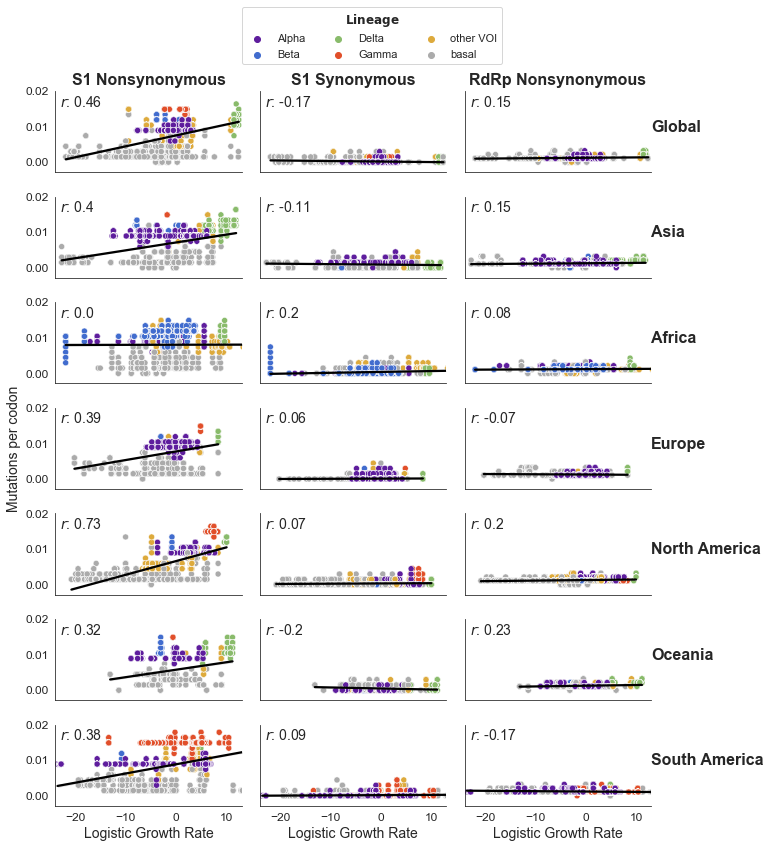

In [180]:
plot_fig1ab(['global','asia','africa', 'europe', 'northamerica', 'oceania', 'southamerica'], 
            filename = 'plots/regional_correlations.png')